In [1]:
!pip install segmentation-models-pytorch
!pip install labelme
!pip install matplotlib
!pip install opencv-python
!pip install albumentations


Предполоджим вы разметили изображение, используя labelme

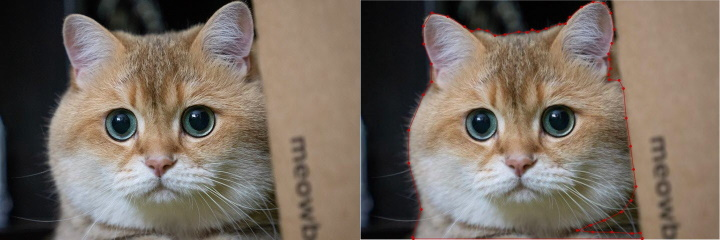

In [1]:
from IPython.display import Image
Image(filename='example_images\cat_labeled.jpg')

Первым делом нужно перевести их в маски, т.е. создать картинку, в которой вместо контуров будут закрашены области, на которых находятся наши объекты.

Labelme имеет встренный инструмент, необходимо просто распарсить json
и сформировать итоговую картинку

In [3]:
import os
import json
import labelme.utils.shape as transform
import matplotlib.pyplot as plt
import cv2

# необходимо сформировать метки для каждого объекта в файлах, непомеченные пиксели - фон (0)
label_name_to_value = {'background': 0}

# функция перевода json в маску
def json2mask(json_path, mask_path_save, show_masks=False):
    '''
    :param json_path: путь к json файлам
    :param mask_path_save: путь к папке, в которую нужно сохранить маски
    :param show_masks: показыать полученные маски после конвертации
    :return: None
    '''

    # считываем все json файлы в папке
    jsons = os.listdir(json_path)

    # проходимся по каждому файлу
    for js in jsons:
        # будем выводить какой файл обрабатывается
        print(f'{js} started')
        # открываем файл
        with open(os.path.join(json_path, js), encoding='utf-8') as f:
            data = json.load(f)

        # проходимся по каждому параметру в json файле в параметре shapes
        for shape in sorted(data['shapes'], key=lambda x: x['label']):
            # cмотрим как названа метка
            label_name = shape['label']
            # если такой метки не встречалось - запоминаем её
            if label_name not in label_name_to_value:
                # присваиваем метке новое значение
                label_value = len(label_name_to_value)
                # запоминаем метку и её значение
                label_name_to_value[label_name] = label_value

        # чтобы получить маску - достаточно вызвать утилиту labelme с полученным словарём
        mask = transform.shapes_to_label([data['imageHeight'], data['imageWidth']], data['shapes'], label_name_to_value)
        # если хотим посмотреть на резульат - просто выводим
        if show_masks:
            plt.imshow(mask[0])
            plt.show()
        # сохраням полученную маску с темже именем
        cv2.imwrite(os.path.join(mask_path_save, js.split('.')[0] + '.jpg'), mask[0])


cat.json started


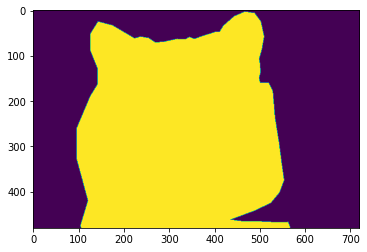

cat0.json started


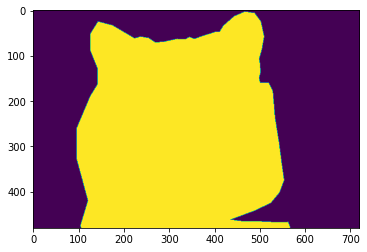

cat1.json started


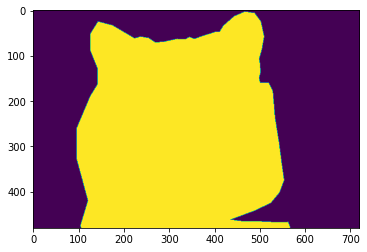

cat2.json started


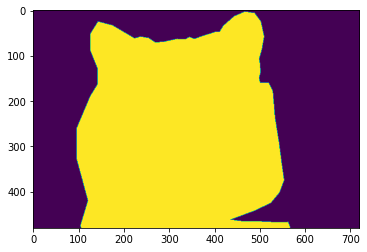

cat3.json started


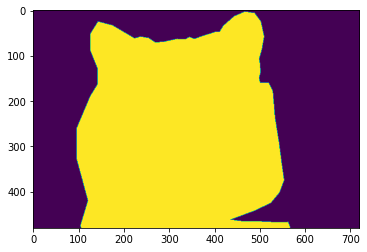

cat4.json started


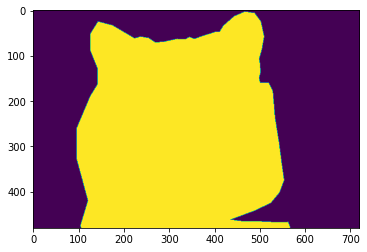

cat5.json started


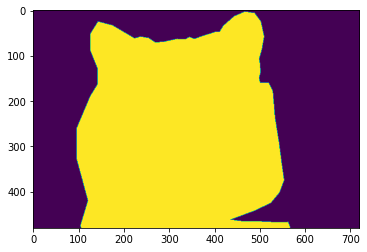

cat6.json started


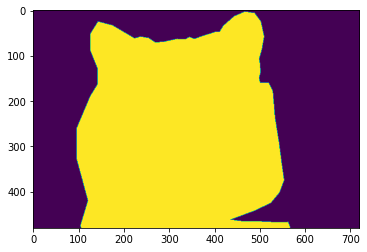

cat7.json started


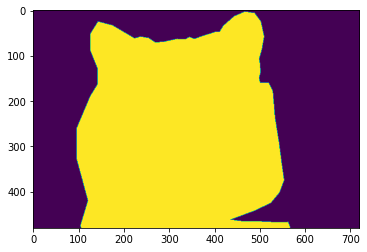

cat8.json started


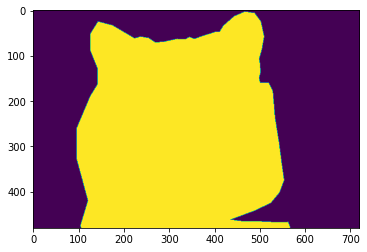

In [4]:
# пусть была структура:
# images -- директория с картинками
# json -- директория с полученными рамзетками
# создаём новую директорию mask

IMG_PATH = 'images/'
JSON_PATH = 'json/'
MASK_PATH = 'mask/'

if not os.path.exists(MASK_PATH):
    os.mkdir(MASK_PATH)
    
# конвертируем json в маски и сразу посмотрим на них

json2mask(JSON_PATH, MASK_PATH, show_masks=True)


## ВАЖНО!

Сейчас у вас в масках хранятся значения 0, 1 и тд. Это значения пикселей, поэтому
в директории вы будите видеть черные картинки.

Для просмотра полученной маски используйте ```matplotlib```

Теперь у нас имеются исходные картинки, и необходимые маски. Следующим шагом
нужно создать сам датасет

Для начала установим ```pytorch```
Если вы хотите установить его без драйверов Cuda и обучать на процессоре, то
запускаем следующую ячейку

In [10]:
!pip install torch torchvision torchaudio

Если же у вас есть карточка Nvidia и вы установили Cuda драйвера, то переходим
на сайт https://pytorch.org/get-started/locally/ и выбираем нужную конфигурацию
затем в следующую ячейку вставляем полученную команду для pip и запускаем ячейку

<img src="example_images/pytorch.png">

In [5]:
# !pip install ...

Теперь необходимо поделить наши данные на 3 порции: тренировочная, валидационная и тестовая.
Как правило берут пропорции 70\20\10

In [6]:
import os
import random

# зафиксируем семечко, чтобы датасет всегда получался одинаковым
random.seed(322)

def split_dataset(images_path, masks_path, train_part=0.7, valid_part = 0.2):
    # проверяем на корректность введеных параметров
    assert train_part + valid_part < 1
    # просматриваем все картинки в директории
    files = os.listdir(images_path)
    # считаем количество файлов
    total_number = len(files)
    # высчитываем количество для каждой части
    train_number = int(total_number * train_part)
    valid_number = int(total_number * valid_part)
    test_number = total_number - train_number - valid_number
    # перемешиваем файлы
    random.shuffle(files)

    train_images = []
    train_masks = []


    valid_images = []
    valid_masks = []

    test_images = []
    test_masks = []
    # набираем нужное количество файлов
    for i in range(train_number):
        train_images.append(os.path.join(images_path, files[i]))
        train_masks.append(os.path.join(masks_path, files[i]))

    for i in range(valid_number):
        valid_images.append(os.path.join(images_path, files[train_number + i]))
        valid_masks.append(os.path.join(masks_path, files[train_number + i]))

    for i in range(test_number):
        test_images.append(os.path.join(images_path, files[train_number + valid_number + i]))
        test_masks.append(os.path.join(masks_path, files[train_number + valid_number + i]))

    return train_images, train_masks, valid_images, valid_masks, test_images, test_masks


In [7]:
train_images, train_annotations, val_images, val_annotations, test_images, test_annotations = split_dataset('images', 'mask')

И теперь сам датасет

In [8]:
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader
import numpy as np

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): путь к изображениям
        masks_dir (str): путь к маскам
        class_values (list): перечень классов, котрые нужно извлекать из масок
        augmentation (albumentations.Compose): трансформации изображения
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): препроцессинг данных
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images,
            masks,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):

        # тут необходимо будет перечислить все ваши классы
        self.CLASSES = ['_background_','cat']

        self.images_fps = images
        self.masks_fps = masks

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # считываем данные
        # Обратите внимание нато, какой у вас формат изображений.
        # Если у вас чёрно-белые картинки, то ставим флаг 0 вместо 1
        image = cv2.imread(self.images_fps[i], 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Если у вас чёрно-белые картинки, то необходимо также добавить ещё
        # одно измерение для каналов
        # image = np.expand_dims(image, axis=2)

        mask = cv2.imread(self.masks_fps[i], 0)

        # дальше вытаскиаем нужные классы из масок. В нашем случае будут все
        # классы
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # если есть трансформации - применяем их
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # если есть препроцессинг - применяем его
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images_fps)

Перед созданием самих датасетов необходимо также сделать препроцессинг

In [9]:
import albumentations as albu

# каналы в pytorhc находятся вначале
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# нормализуем картинку, для лучшего обучения
def get_preprocessing_fn(x, **kwargs):
    return x / 255.0

# далее albumentations сделает всё за нас
def get_preprocessing():
    preprocess = [
        albu.Lambda(image=get_preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]
    return albu.Compose(preprocess)

In [10]:
CLASSES = list(label_name_to_value.keys())[1:]
train_dataset = Dataset(
    train_images,
    train_annotations,
    preprocessing=get_preprocessing(),
    classes=CLASSES, # берём все классы кроме фона
)

valid_dataset = Dataset(
    val_images,
    val_annotations,
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

test_dataset_vis = Dataset(
    test_images, test_annotations,
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

# И теперь обернём это всё в DataLoader. Это позволит не загружать все картинки в память,
# а динамически считывать их порциями

# batch_size -- размер порции, обычно кратен 2, чем больше порция, тем больше требуется памяти
# shuffle -- необходимо ли перемешивать датасет. В случае тренировки мы хотим разные комбинации,
# а на валидации нам не важно
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset_vis)

Посмотрим немного на визуализацию всего проделанного добра

In [11]:
def visualize(**images):
    """Вывести изображжения в ряд."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

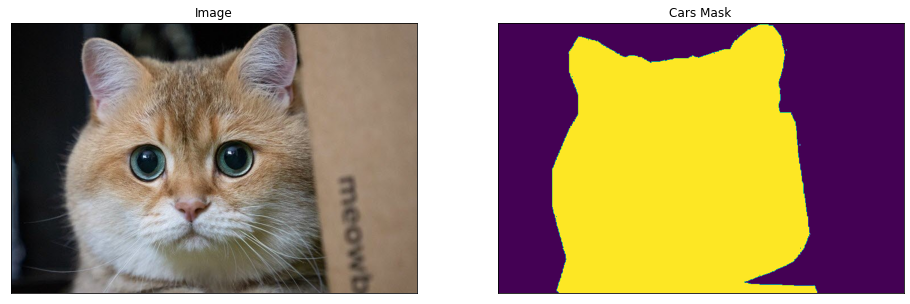

In [12]:
vis_dataset = Dataset(
    test_images, test_annotations,
    classes=CLASSES,
)

image, mask = vis_dataset[0] # get some sample
visualize(
    image=image,
    cars_mask=mask.squeeze(),
)

Теперь мы переходим к созданию самих моделей. Писать модели с 0 -- неблагодарное и
мучительное дело, да ещё и ошибётесь где-нибудь. Поэтому я предалгаю использовать
библиотеку ```segmentation_models```. Она содержит уже сконфигурированные сети
популярных и рабочих архитектур. Самая прорывная архитектура, с которой произошёл
БУМ в задаче сегментации -- Unet. Её и обучим.

In [13]:
import segmentation_models_pytorch as smp

# определим функцию активации нейронной сети. Если нам нужно определить всего один класс,
# будем всегда использовать сигмоиду. Для многоклассовой сегментации поставим
# 'softmax2d'
ACTIVATION = 'sigmoid'

model = smp.Unet(
        encoder_depth=4, # чем меньше глубина, тем быстрее работает. А также нужно, чтобы ваши размеры изображения были кратны 2^depth
        decoder_channels=[256, 128, 64, 32], # при увеличении глубины добавляем новые элементы (селдующее 16 и тд)
        classes=len(CLASSES),
        activation=ACTIVATION,
    )

# !!!Если у вас черно-белые изображения -- не забудьте поставить количество входных каналов равное 1!!!!
# model.encoder.set_in_channels(1)

дальше необходимо определить функцию потерь, метрики, а также оптимизатор

In [14]:
import torch

# Dice Loss показывает довольно хорошие результаты, поэтому менять особо нет смысла
loss = smp.utils.losses.DiceLoss()
# Самая классическая метрика для задачи сегментации Intersaction over Union score(IoU)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
# самый популярный оптимизатор Adam, который отлично реализует градиентный спуск
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr= 1e-3),
])

Далее необходимо сформировать тренировочные и валидационные шаги во время эпохи.
```segmentation_model``` имеет встроенные конфигураторы, остаётся только вызвать их

In [15]:
DEVICE = 'cpu' # 'cuda' если у вас установлены драйвера и pytorch для видеокарт

train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

Как правило, обучение длится очень долго и если что-то произойдёт -- начинать сначала не очень
хочется... Поэтому лучше создать папку с логами и сохранять туда лучшие полученные модели


In [16]:
path_to_save = 'logs'

# проверяем создана ли уже эта папка
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

И наконец мы доходим до самого... Интересного. Обучение нейронной сети

In [17]:
EPOCHS = 5
max_score = 0
# создаём путь до модели
model_path = os.path.join(path_to_save, f'model.ptn')

for i in range(0, EPOCHS):

        print(f'\nEpoch: {i}')
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        # Сохраняем модель, когда находим лучший результат
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, model_path)
            print('Model saved!')

        # При длительном обучении, как правило, изменяют скорость обучения
        # (learning rate или lr), чтобы сеть лучше сходилась к локальным точкам
        # В нашем же случае только 5 эпох, так что ничего особо менять не нужно
        if i == 100:
            optimizer.param_groups[0]['lr'] = 1e-4
            print('Decrease decoder learning rate to 1e-4!')

        if i == 130:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')

        if i == 160:
            optimizer.param_groups[0]['lr'] = 1e-6
            print('Decrease decoder learning rate to 1e-6!')


Epoch: 0
valid: 100%|█████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it, dice_loss - 0.2436, iou_score - 0.5589]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it, dice_loss - 0.08739, iou_score - 0.8747]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it, dice_loss - 0.04249, iou_score - 0.9403]
Model saved!

Epoch: 3
valid: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it, dice_loss - 0.02512, iou_score - 0.9649]
Model saved!

Epoch: 4
valid: 100%|████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it, dice_loss - 0.01705, iou_score - 0.9775]
Model saved!


По факту всё, вы обучили свою сеть и готовы пихать в неё свои данные.
Но для начала проверим на тестовом датасете.

In [18]:
# загружаем лучшую модель
best_model = torch.load(model_path)

# создаём новый конфигуратор
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

# прогоняем через него тестовый датасет
logs = test_epoch.run(test_loader)

valid: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s, dice_loss - 0.01705, iou_score - 0.9775]


И теперь проверим что у нас получилось на выходе сети
Для начала создадим функцию, которая будет приводить наши изображения в нужный формат
и прогонять через нейронную сеть

In [19]:
def process_image(model, image, device):
    masks = []
    image = get_preprocessing_fn(to_tensor(image))
    image = torch.from_numpy(image).unsqueeze(0).to(device)
    pr_mask = model.predict(image)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    masks.append(pr_mask)

    return np.array(masks)

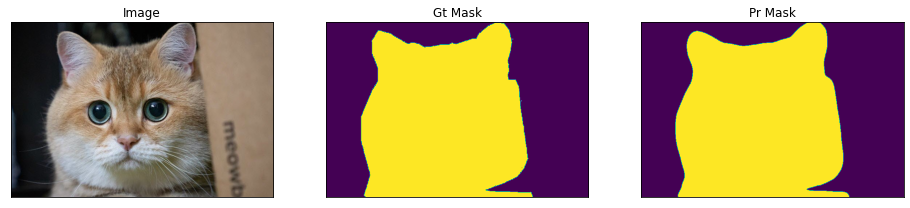

In [20]:
for image, gt_mask in vis_dataset:


    pr_mask = process_image(best_model, image, DEVICE)

    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

Вот это да!!! наша сеть смогла в точности увидеть нашего котика! Хотя это не удивительно,
ведь кроме котика она ничего и не видела. Попробуем ка мы подкинуть нашей сети другого кота...

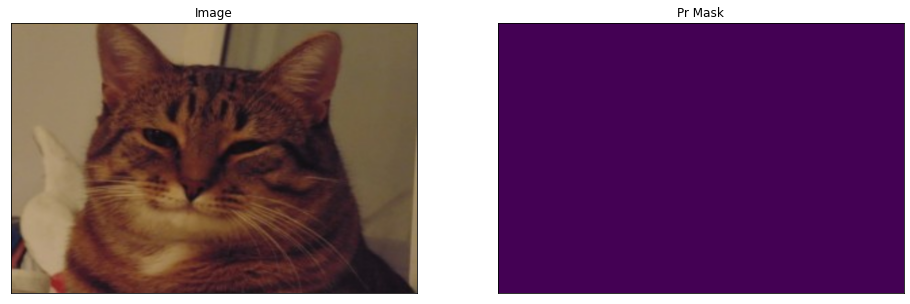

In [21]:
image = cv2.imread('example_images/new_cat.jpg', 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (720, 480))

pr_mask = process_image(best_model, image, DEVICE)

visualize(
    image=image.squeeze(),
    pr_mask=pr_mask.squeeze(),
)

Жтож... Наша сеть не сможет распознать котика из мемов, а жаль...
